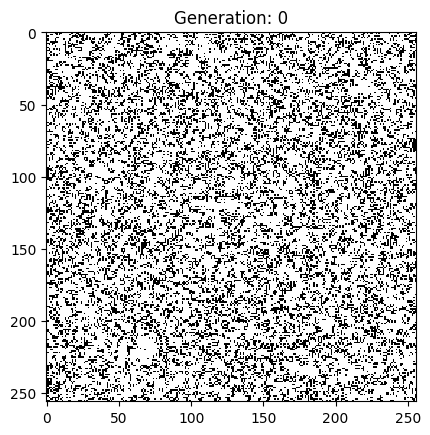

In [11]:
"""
Sample code using pycuda library kernel function to implement the LIFE game (Conway's Game of Life) invented by John Conway in 1970, to demonstrate the thread block and grid application, and visualize the whole process using matplotlib.

The game consists of a grid of cells, each of which can be in one of two states, alive or dead. The game progresses in discrete time steps, with the state of each cell in the grid being updated based on the states of its neighbors. The rules are as follows:
- Any live cell with fewer than two live neighbors dies, as if by underpopulation.
- Any live cell with two or three live neighbors lives on to the next generation.
- Any live cell with more than three live neighbors dies, as if by overpopulation.
- Any dead cell with exactly three live neighbors becomes a live cell, as if by reproduction.

The code uses a CUDA kernel function to update the state of each cell in the grid based on the rules of the game. The grid is initialized with random alive/dead cells, and the kernel function is called in a loop to simulate the progression of the game. The grid is visualized using matplotlib to show the evolution of the game over time.

The code demonstrates how to write a CUDA kernel function, allocate device memory, copy data between host and device, launch the kernel function with specified block and grid dimensions, and visualize the results of the simulation using matplotlib.
"""
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt

# CUDA kernel function
kernel_code = """
#define ALIVE 1
#define DEAD 0

__global__ void gameOfLife(int *grid, int *newGrid, int rows, int cols) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    
    if (row >= rows || col >= cols)
        return;
    
    int numNeighbors = 0;
    for (int i = -1; i <= 1; i++) {
        for (int j = -1; j <= 1; j++) {
            if (i == 0 && j == 0)
                continue;
            int r = (row + i + rows) % rows;
            int c = (col + j + cols) % cols;
            numNeighbors += grid[r * cols + c];
        }
    }
    
    if (grid[row * cols + col] == ALIVE) {
        if (numNeighbors < 2 || numNeighbors > 3)
            newGrid[row * cols + col] = DEAD;
        else
            newGrid[row * cols + col] = ALIVE;
    } else {
        if (numNeighbors == 3)
            newGrid[row * cols + col] = ALIVE;
        else
            newGrid[row * cols + col] = DEAD;
    }
}
"""

# Compile the CUDA kernel
mod = SourceModule(kernel_code)
gameOfLife = mod.get_function("gameOfLife")

# Grid dimensions
rows = 256
cols = 256

# Create initial grid with random alive/dead cells
grid = np.random.choice([0, 1], size=(rows, cols)).astype(np.int32)

# Allocate device memory for grids
d_grid = cuda.mem_alloc(grid.nbytes)
d_newGrid = cuda.mem_alloc(grid.nbytes)

# Copy initial grid to device
cuda.memcpy_htod(d_grid, grid)

# Set block and grid dimensions
block_dim = (16, 16, 1)
grid_dim = (cols // block_dim[0], rows // block_dim[1])

# Create figure for visualization
fig, ax = plt.subplots()
img = ax.imshow(grid, cmap='binary', interpolation='nearest')

# Simulation loop to keep showing the animation
for generation in range(100):
    # Launch kernel
    gameOfLife(d_grid, d_newGrid, np.int32(rows), np.int32(cols), block=block_dim, grid=grid_dim)
    
    # Swap grids
    d_grid, d_newGrid = d_newGrid, d_grid
    
    # Copy grid from device to host for visualization
    cuda.memcpy_dtoh(grid, d_grid)
    
    # Update plot
    img.set_data(grid)
    ax.set_title(f"Generation: {generation}")
    plt.pause(0.01)

# Keep the plot window open
plt.show()
